In [1]:
# from langchain.tools import tool
from langchain.chat_models import init_chat_model
from langgraph.graph import StateGraph, MessagesState, START, END
from langchain.messages import AnyMessage
from typing_extensions import TypedDict, Annotated
import operator
from langchain.messages import SystemMessage
# from langchain.messages import ToolMessage
from typing import Literal

c:\Users\jw160\project\RAG\.venv\Lib\site-packages\langchain_core\_api\deprecation.py:26: UserWarning: Core Pydantic V1 functionality isn't compatible with Python 3.14 or greater.
  from pydantic.v1.fields import FieldInfo as FieldInfoV1


In [45]:
from langchain_core.retrievers import BaseRetriever

In [2]:
from langchain_huggingface.embeddings import HuggingFaceEndpointEmbeddings
from langchain_core.vectorstores import InMemoryVectorStore
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_core.documents import Document
from langchain.messages import HumanMessage, AIMessage

In [3]:
# 샘플 문서 데이터
documents = [
    "인공지능(AI)은 컴퓨터 시스템이 인간의 지능을 모방하여 학습하고 추론할 수 있도록 하는 기술입니다.",
    "머신러닝은 AI의 한 분야로, 데이터로부터 패턴을 학습하여 예측이나 분류를 수행합니다.",
    "딥러닝은 신경망을 사용하여 복잡한 패턴을 학습하는 머신러닝의 하위 분야입니다.",
    "자연어처리(NLP)는 인간의 언어를 컴퓨터가 이해하고 처리할 수 있도록 하는 AI 기술입니다.",
    "컴퓨터 비전은 이미지나 비디오에서 의미 있는 정보를 추출하는 AI 분야입니다."
]

# Document 객체로 변환
docs = [Document(page_content=text) for text in documents]

# 텍스트 분할
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=512,
    chunk_overlap=50
)
splits = text_splitter.split_documents(docs)

In [4]:
embeddings = HuggingFaceEndpointEmbeddings(client="http://127.0.0.1:8080/")
vectorstore = InMemoryVectorStore.from_documents(splits, embeddings)

In [5]:
class MessagesState(TypedDict):
    messages: Annotated[list[AnyMessage], operator.add]
    llm_calls: int

In [46]:
from typing import List

In [47]:
class SimpleRetriever(BaseRetriever):
    docs: List[Document]
    k: int = 5

    def _get_relevant_documents(self, query: str) -> List[Document]:
        # Implementation logic to return relevant documents based on the query
        # For example, returning the first 'k' documents for simplicity
        return self.docs[:self.k]

In [11]:
model = init_chat_model(
    "smollm2",
    model_provider="ollama",
    base_url="http://localhost:11434",
    temperature=0,
    max_tokens=50,
    model_kwargs={
    "num_predict": 50  # Ollama 전용 파라미터
    }
)


In [61]:
def retriever_call(state: dict):  
    retriever = vectorstore.as_retriever(
        search_type="similarity",  # "similarity_score_threshold" 대신
        search_kwargs={"k": 2}  # score_threshold 대신 k 사용
    )
    return {
        "retriever": retriever
    }

In [74]:
def llm_call(state: dict):
    """LLM decides whether to call a tool or not"""

    return {
        "messages": [
            model.invoke(
                [
                    SystemMessage(
                        content="당신은 키워드 추출 전문가입니다. 주어진 문장에서 핵심 키워드만 뽑아 한글 쉼표(,)로 구분하여 나열하세요. 불필요한 설명 없이 키워드만 답변하세요."
                    )
                ]
                + state["messages"]
            )
        ],
        "llm_calls": state.get('llm_calls', 0) + 1
    }

In [ ]:
#  content="당신은 감정 분석 전문가입니다. 문장의 감정을 분석하여 반드시 '긍정' 또는 '부정' 중 하나만 답변하세요. 추가 설명 없이 감정만 판단하세요"

In [ ]:
# from pydantic import BaseModel, Field
# from typing import Literal
# import re

# class SentimentResponse(BaseModel):
#     """감정 분석 결과"""
#     sentiment: Literal["긍정", "부정"] = Field(description="문장의 감정")

# def llm_call_improved(state: dict):
#     """개선된 LLM 호출 - 구조화된 출력 사용"""
    
#     # Structured output 사용
#     structured_model = model.with_structured_output(SentimentResponse)
    
#     response = structured_model.invoke(
#         [
#             SystemMessage(
#                 content="""당신은 감정 분석 전문가입니다. 
# 문장의 감정을 분석하여 반드시 '긍정' 또는 '부정' 중 하나만 답변하세요.
# 추가 설명 없이 감정만 판단하세요."""
#             )
#         ]
#         + state["messages"]
#     )
    
#     # Pydantic 모델에서 sentiment 추출
#     from langchain.messages import AIMessage
#     return {
#         "messages": [AIMessage(content=response.sentiment)],
#         "llm_calls": state.get('llm_calls', 0) + 1
#     }

In [75]:
graph = StateGraph(MessagesState)
graph.add_node(llm_call)
graph.add_node(retriever_call)
graph.add_edge(START, "retriever_call")
graph.add_edge("retriever_call", "llm_call")
graph.add_edge("llm_call", END)
graph = graph.compile()

In [76]:
graph.invoke({"messages": [{"role": "user", "content": "오늘 날씨가 좋아요."}]})

{'messages': [{'role': 'user', 'content': '오늘 날씨가 좋아요.'},
  AIMessage(content='오늘 날씨', additional_kwargs={}, response_metadata={'model': 'smollm2', 'created_at': '2025-12-04T17:16:25.659094802Z', 'done': True, 'done_reason': 'stop', 'total_duration': 10208240350, 'load_duration': 47638440, 'prompt_eval_count': 213, 'prompt_eval_duration': 6762084319, 'eval_count': 13, 'eval_duration': 3310999249, 'logprobs': None, 'model_name': 'smollm2', 'model_provider': 'ollama'}, id='lc_run--adefdbb0-5505-4d00-81a5-f2f93d92edcc-0', usage_metadata={'input_tokens': 213, 'output_tokens': 13, 'total_tokens': 226})],
 'llm_calls': 1}

In [77]:
graph.invoke({"messages": [{"role": "user", "content": "컴퓨터 비전에 대해 알려줘"}]})

{'messages': [{'role': 'user', 'content': '컴퓨터 비전에 대해 알려줘'},
  AIMessage(content='"컴퓨터 비전"', additional_kwargs={}, response_metadata={'model': 'smollm2', 'created_at': '2025-12-04T17:16:32.461133398Z', 'done': True, 'done_reason': 'stop', 'total_duration': 6780492043, 'load_duration': 48191430, 'prompt_eval_count': 220, 'prompt_eval_duration': 2196875595, 'eval_count': 18, 'eval_duration': 4509728853, 'logprobs': None, 'model_name': 'smollm2', 'model_provider': 'ollama'}, id='lc_run--f57fce04-6174-436a-8b30-032efbf0099f-0', usage_metadata={'input_tokens': 220, 'output_tokens': 18, 'total_tokens': 238})],
 'llm_calls': 1}

In [ ]:
# 키워드 추출, 감정 분석 등 활용 고려

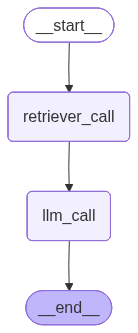

In [65]:
from IPython.display import Image, display
display(Image(graph.get_graph(xray=True).draw_mermaid_png()))